In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import os
import xlsxwriter
import pandas as pd # Excel
import struct # Binary writing

import scipy.io as sio # Read .mat files
import h5py

import time


import scipy.signal
import scipy.ndimage

import sklearn.metrics as skmet
import sklearn.decomposition as skdec
import sklearn.linear_model as sklin
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import normalize
from sklearn import svm
from sklearn import neighbors

C:\Users\sarytky\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Create test image
def test_image():
    test_image = np.zeros((20, 30))
    for i in range(20):
        for j in range(30):
            test_image[i,j] = i + j
    return test_image

#Regression
def regress(features,score):
    pred = []
    #Leave one out split
    loo = LeaveOneOut()	
    for trainidx, testidx in loo.split(features):
        #Indices
        X_train, X_test = features[trainidx], features[testidx]
        X_test -= X_train.mean(0)
        X_train -= X_train.mean(0)

        Y_train, Y_test = score[trainidx], score[testidx]		
        #Linear regression		
        regr = sklin.Ridge(alpha=1)
        regr.fit(X_train,Y_train)
        #Predicted score		
        pred.append(regr.predict(X_test))

    return np.array(pred)

#Logistic regression
def logreg(features,score):
    pred = []
    #Leave one out split
    loo = LeaveOneOut()	
    for trainidx, testidx in loo.split(features):
        #Indices
        X_train, X_test = features[trainidx], features[testidx]
        X_test -= X_train.mean(0)
        X_train -= X_train.mean(0)

        Y_train, Y_test = score[trainidx], score[testidx]		
        #Linear regression
        regr = sklin.LogisticRegression(solver='newton-cg',max_iter=1000)
        regr.fit(X_train,Y_train)
        #Predicted score
        P = regr.predict_proba(X_test)
        pred.append(P)

    pred = np.array(pred)
    pred = pred[:,:,1]
    return pred.flatten()

#MRELBP
def MRELBP(im,N,R,r,w_c,w_r):
    #Takes Median Robust Extended Local Binary Pattern from image im
    #Uses N neighbours from radii R and r, R must be larger than r
    #Median filter uses kernel sizes w_c for center pixels, w_r[0] for larger radius and w_r[1]
    #for smaller radius	
    #Grayscale values are centered at their mean and scales with global standad deviation

    #Mean grayscale value and std
    muI = im.mean()
    stdI = im.std()

    #Centering and scaling with std
    I = (im-muI)/stdI

    #Median filtering
    Ic = scipy.signal.medfilt(I,w_c)
    #Center pixels
    d = round(R+(w_r[0]-1)/2)
    Ic = Ic[d:-d,d:-d]
    #Subtracting the mean pixel value from center pixels
    Ic = Ic-Ic.mean()
    #Bining center pixels
    Chist = np.zeros((1,2))
    Chist[0,0] = np.sum(Ic>=-1e-06)
    Chist[0,1] = np.sum(Ic<-1e-06)

    #Median filtered images for large and small radius
    IL = scipy.signal.medfilt(I,w_r[0])
    d1 = round((w_r[0]-1)/2)
    IL = IL[d1:-d1,d1:-d1]
    IS = scipy.signal.medfilt2d(I,w_r[1])
    d2 = round((w_r[1]-1)/2)
    IS = IS[d2:-d2,d2:-d2]

    #print('Center filtered') # Filtered image    
    #print(Ic[0,0:30]) # Filtered image

    #row1,col1 = np.shape(IS)    
    #print("Size (IS): " + str(row1) + ", " + str(col1))
    # Save filtered images
    #Iconvert1 = (Ic-np.min(Ic))/(np.max(Ic)-np.min(Ic))*255 
    #cv2.imwrite(r'C:\Users\sarytky\Desktop\trials\Median_python_c.png', Iconvert1) # not scaled to 0-255
    #Iconvert2 = (IS-np.min(IS))/(np.max(IS)-np.min(IS))*255 
    #cv2.imwrite(r'C:\Users\sarytky\Desktop\trials\Median_python_s.png', Iconvert2) # not scaled to 0-255
    #Iconvert3 = (IL-np.min(IL))/(np.max(IL)-np.min(IL))*255 
    #cv2.imwrite(r'C:\Users\sarytky\Desktop\trials\Median_python_l.png', Iconvert3) # not scaled to 0-255

    #Neighbours
    pi = np.pi
    #Empty arrays for the neighbours
    row,col = np.shape(Ic)
    NL = np.zeros((row,col,N))
    NS = np.zeros((row,col,N))
    #print("Size (Ic): " + str(row) + ", " + str(col))
    for k in range(N):
        #Angle to the neighbour
        theta = 0+k*(-1*2*pi/N)
        #Large neighbourhood
        x = R+R*np.cos(theta)
        y = R+R*np.sin(theta)
        if abs(x-round(x)) < 1e-06 and abs(y-round(y)) < 1e-06:
            x = int(round(x))
            y = int(round(y))
            P = IL[y:y+row,x:x+col]
        else:
            P = imbilinear(IL,col,x,row,y)
        NL[:,:,k] = P
        #Small neighbourhood
        x = R+r*np.cos(theta)
        y = R+r*np.sin(theta)
        if abs(x-round(x)) < 1e-06 and abs(y-round(y)) < 1e-06:
            x = int(round(x))
            y = int(round(y))
            P = IS[y:y+row,x:x+col]
        else:
            P = imbilinear(IS,col,x,row,y)
        NS[:,:,k] = P
    #Thresholding

    #Thresholding radial neighbourhood
    NR = NL-NS

    #Subtraction of means
    #Large neighbourhood
    NLmu = NL.mean(axis=2)		
    #Small neighbouhood
    NSmu = NS.mean(axis=2)

    for k in range(N):
        NL[:,:,k] = NL[:,:,k]-NLmu
        NS[:,:,k] = NS[:,:,k]-NSmu	

    #Converting to binary images and taking the lbp values

    #Initialization of arrays
    lbpIL = np.zeros((row,col))
    lbpIS = np.zeros((row,col))
    lbpIR = np.zeros((row,col))

    for k in range(N):
        lbpIL = lbpIL+(NL[:,:,k]>=-1e-06)*2**k # NOTE ACCURACY FOR THRESHOLDING!!!
        lbpIS = lbpIS+(NS[:,:,k]>=-1e-06)*2**k
        lbpIR = lbpIR+(NR[:,:,k]>=-1e-06)*2**k

    #Binning
    Lhist = np.zeros((1,2**N))
    Shist = np.zeros((1,2**N))
    Rhist = np.zeros((1,2**N))
    for k in range(2**N):
        Lhist[0,k] = np.sum(lbpIL==k)
        Shist[0,k] = np.sum(lbpIS==k)
        Rhist[0,k] = np.sum(lbpIR==k)

    #Chist = 1/np.linalg.norm(Chist)*Chist
    #Lhist = 1/np.linalg.norm(Lhist)*Lhist
    #Shist = 1/np.linalg.norm(Shist)*Shist
    #Rhist = 1/np.linalg.norm(Rhist)*Rhist
    return Chist,Lhist,Shist,Rhist, lbpIL, lbpIS, lbpIR

#Mapping
def getmapping(N):
    #Defines rotation invariant uniform mapping for lbp of N neighbours
    newMax = N + 2
    table = np.zeros((1,2**N))
    for k in range(2**N):
        #Binary representation of bin number
        binrep = np.binary_repr(k,N)
        #Convert string to list of digits
        i_bin = np.zeros((1,len(binrep)))
        for ii in range(len(binrep)):
            i_bin[0,ii] = int(float(binrep[ii]))
        #Rotation
        j_bin = np.roll(i_bin,-1)
        #uniformity
        numt = np.sum(i_bin!=j_bin)		
        #Binning
        if numt <= 2:
            b = np.binary_repr(k,N)
            c=0
            for ii in range(len(b)):
                c = c+int(float(b[ii]))
            table[0,k] = c
        else:
            table[0,k] = N+1
    #num = newMax
    return table

#Apply mapping to lbp
def maplbp(bin,mapping):
    #Applies mapping to lbp bin
    #Number of bins in output
    N = int(np.max(mapping))
    #print(N)
    #Empty array
    outbin = np.zeros((1,N+1))
    for k in range(N+1):
        #RIU indices
        M = mapping==k
        #Extract indices from original bin to new bin
        outbin[0,k] = np.sum(M*bin)
    return outbin

#Bilinear interpolation
def imbilinear(im,col,x,row,y):
    #Takes bilinear interpotalion from image
    #Starts from coordinates [y,x], ends at row,col
    x1 = int(np.floor(x))
    x2 = int(np.ceil(x))
    y1 = int(np.floor(y))
    y2 = int(np.ceil(y))
    Q11 = im[y1:y1+row,x1:x1+col]
    Q21 = im[y1:y1+row,x2:x2+col]
    Q12 = im[y2:y2+row,x1:x1+col]
    Q22 = im[y2:y2+row,x2:x2+col]
    R1 = ((x2-x)/(x2-x1+1e-12))*Q11+((x-x1)/(x2-x1+1e-12))*Q21
    R2 = ((x2-x)/(x2-x1+1e-12))*Q12+((x-x1)/(x2-x1+1e-12))*Q22
    P = ((y2-y)/(y2-y1+1e-12))*R1+((y-y1)/(y2-y1+1e-12))*R2
    return P

# Image padding
def impadding(im, padlength):
    row,col = np.shape(im)
    im_pad = np.zeros((row + 2 * padlength, col + 2 * padlength))
    # Center
    im_pad[padlength:-padlength, padlength:-padlength] = im
    plt.imshow(im_pad)
    plt.show()

    return im_pad

#Scikit PCA
def ScikitPCA(features,ncomp):
    pca = skdec.PCA(n_components=ncomp, svd_solver='full')
    score = pca.fit(features).transform(features)
    return pca, score

#Principal component analysis
def PCA(features,ncomp):	
    #Feature dimension, x=num variables,N=num observations
    x,N = np.shape(features)
    #Mean feature
    mean_f = np.mean(features,axis=1)
    #Centering
    centrd = np.zeros((x,N))
    for k in range(N):
        centrd[:,k] = features[:,k]-mean_f

    #PCs from covariance matrix if N>=x, svd otherwise
    if False:
        #Covariance matrix
        Cov = np.zeros((x,x))
        f = np.zeros((x,1))
        for k in range(N):		
            f[:,0] = centrd[:,k]
            Cov = Cov+1/N*np.matmul(f,f.T)

        #Eigen values
        E,V = np.linalg.eig(Cov)		
        #Sort eigenvalues and vectors to descending order
        idx = np.argsort(E)[::-1]
        V = np.matrix(V[:,idx])
        E = E[idx]

        for k in range(ncomp):						
            s = np.matmul(V[:,k].T,centrd).T			
            try:
                score = np.concatenate((score,s),axis=1)
            except NameError:
                score = s
            p = V[:,k]
            try:
                pcomp = np.concatenate((pcomp,p),axis=1)
            except NameError:
                pcomp = p
    else:
        #PCA with SVD
        u,s,v = np.linalg.svd(centrd,compute_uv=1)
        pcomp = v[:,:ncomp]
        # Save results
        writer = pd.ExcelWriter(r'C:\Users\sarytky\Desktop\trials' + r'\PCA_test.xlsx')
        df1 = pd.DataFrame(centrd)
        df1.to_excel(writer, sheet_name='dataAdjust')
        df2 = pd.DataFrame(u)
        df2.to_excel(writer, sheet_name='u')
        df3 = pd.DataFrame(s)
        df3.to_excel(writer, sheet_name='s')
        df4 = pd.DataFrame(v)
        df4.to_excel(writer, sheet_name='v')        
        writer.save()
        np.savetxt(r'C:\Users\sarytky\Desktop\trials' + '\\''dataAdjust_python.csv', centrd, delimiter=',')

        score = np.matmul(u,s).T[:,1:ncomp]
    return pcomp,score

#Local grayscale standardization
def localstandard(im,w1,w2,sigma1,sigma2):
    #Centers grayscales with Gaussian weighted mean
    #Gaussian kernels
    kernel1 = Gauss2D(w1,sigma1)
    kernel2 = Gauss2D(w2,sigma2)
    #Blurring
    blurred1 = scipy.ndimage.convolve(im,kernel1)
    blurred2 = scipy.ndimage.convolve(im,kernel2)
    #print(blurred1[11,:])
    #Centering grayscale values
    centered = im-blurred1
    #Standardization
    std = (scipy.ndimage.convolve(centered**2,kernel2))**0.5
    new_im = centered/(std+1e-09)
    return new_im

#Gaussian kernel
def Gauss2D(w,sigma):
    #Generates 2d gaussian kernel
    kernel = np.zeros((w,w))
    #Constant for centering
    r = (w-1)/2
    for ii in range(w):
        for jj in range(w):
            x = -((ii-r)**2+(jj-r)**2)/(2*sigma**2)
            kernel[ii,jj] = np.exp(x)
    #Normalizing the kernel
    kernel = 1/np.sum(kernel)*kernel
    return kernel

def loadbinary(path, datatype = np.int32):
    if datatype == np.float64:
        bytesarray = np.fromfile(path, dtype = np.int64) # read everything as int32
    else:
        bytesarray = np.fromfile(path, dtype = np.int32) # read everything as int32
    w = bytesarray[0]
    l = int((bytesarray.size - 1) / w)
    with open(path, "rb") as f: # open to read binary file
        if datatype == np.float64:
            f.seek(8) # skip first integer (width)
        else:
            f.seek(4) # skip first integer (width)
        features = np.zeros((w,l))
        for i in range(w):
            for j in range(l):
                if datatype == np.int32:
                    features[i, j] = struct.unpack('<i', f.read(4))[0]  
                    # when reading byte by byte (struct), 
                    #data type can be defined with every byte
                elif datatype == np.float32:
                    features[i, j] = struct.unpack('<f', f.read(4))[0]  
                elif datatype == np.float64:
                    features[i, j] = struct.unpack('<d', f.read(8))[0]  
        return features

def writebinaryweights(path, ncomp, eigenvectors, singularvalues, weights):
    with open(path, "wb") as f:
        f.write(struct.pack('<i', eigenvectors.shape[1])) # Width
        f.write(struct.pack('<i', ncomp)) # Number of components
        # Eigenvectors 
        for i in range(eigenvectors.shape[0]):
            for j in range(eigenvectors.shape[1]):
                f.write(struct.pack('<f', eigenvectors[i, j]))
        # Singular values
        for i in range(singularvalues.shape[0]):
            f.write(struct.pack('<f', singularvalues[i]))
        # Weights
        for i in range(weights.shape[0]):
            f.write(struct.pack('<f', weights[i]))            
    return True

def writebinaryimage(path, image, dtype):
    with open(path, "wb") as f:
        f.write(struct.pack('<i', image.shape[0])) # Width
        # Image values as float
        for i in range(image.shape[0]):
            for j in range(image.shape[1]):
                if dtype == 'float':
                    f.write(struct.pack('<f', image[i, j]))
                if dtype == 'double':
                    f.write(struct.pack('<d', image[i, j]))
                if dtype == 'int':
                    f.write(struct.pack('<i', image[i, j]))                    
    return True

### Calculate LBP features from .dat mean and std images

['15_L6TL_2_cc_mean.dat', '15_L6TL_2_cc_std.dat', '15_L6TL_2_deep_mean.dat', '15_L6TL_2_deep_std.dat', '15_L6TL_2_surface_mean.dat', '15_L6TL_2_surface_std.dat', 'Images']
Processing: 15_L6TL_2_cc_mean.dat


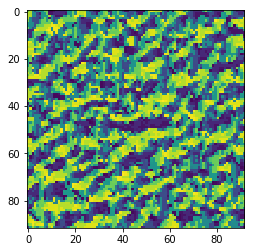

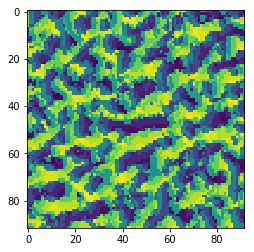

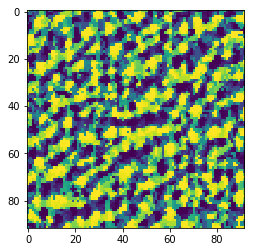

Processing: 15_L6TL_2_deep_mean.dat


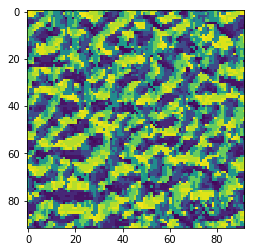

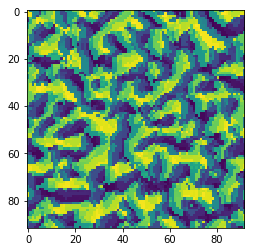

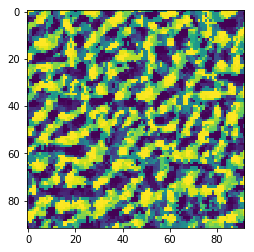

Processing: 15_L6TL_2_surface_mean.dat


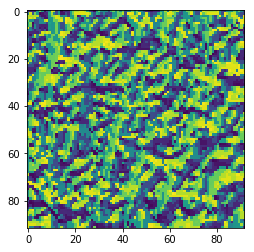

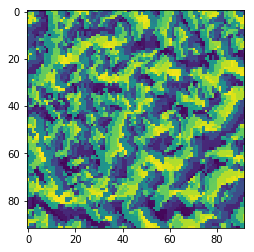

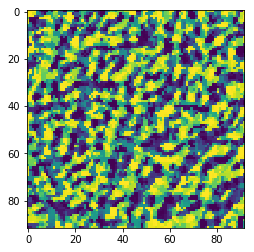

Processing: Images
[-2.05799904e+02  3.32456446e+02  4.26325641e-14]


ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: True

In [10]:
#Start time
start_time = time.time()
impath = r'Z:\3DHistoData\SurfaceImages'
savepath = r'Z:\3DHistoData\Grading'

# Load grades to array
grades = pd.read_excel(r'C:\Users\sarytky\Desktop\trials' + r'\PTAgreiditjanaytteet.xls', 'Sheet1')
grades = pd.DataFrame(grades).values
g = grades[:,2].astype('int')
grades = grades[:,1:2]

#Calculate MRELBP from dataset

# Parameters
dict = {'N':8, 'R':3,'r':1,'wc':3,'wr':(3,3)}
mapping = getmapping(dict['N']) # mapping

files = os.listdir(impath)
files.sort()

print(files)
features = None # Reset feature array

for k in range(0, len(files), 2):
    #Load file
    print('Processing: ' + files[k])
    
    file = os.path.join(impath,files[k])
    try:
        Mz = loadbinary(file, np.float64)
    except:
        continue
    file = os.path.join(impath,files[k + 1])
    try:
        sz = loadbinary(file, np.float64)
    except:
        continue
    
    #Combine mean and sd images
    image = Mz+sz
    #Grayscale normalization
    image = localstandard(image,23,5,5,1)
    #print(image[0,:]) # Normalized image
    # LBP
    Chist,Lhist,Shist,Rhist, lbpIL, lbpIS, lbpIR = MRELBP(image,dict['N'],dict['R'],dict['r'],dict['wc'],dict['wr'])
    f1 = Chist
    f2 = maplbp(Lhist,mapping)
    f3 = maplbp(Shist,mapping)
    f4 = maplbp(Rhist,mapping)
    #Concatenate features
    f = np.concatenate((f1.T,f2.T,f3.T,f4.T),axis=0)
    try:
        features = np.concatenate((features,f),axis=1)
    except ValueError:
        features = f
    # Save images
    cv2.imwrite(savepath + '\\' + files[k][:-9] + '.png', lbpIL)
    plt.imshow(lbpIS)
    plt.show()
    plt.imshow(lbpIL)
    plt.show()
    plt.imshow(lbpIR)
    plt.show()

# Save features
writer = pd.ExcelWriter(savepath + r'\LBP_features_python.xlsx')
df1 = pd.DataFrame(features)
df1.to_excel(writer, sheet_name='LBP_features')
writer.save()

#PCA
pca, score = ScikitPCA(features.T,10)
#pca, score = PCA(features,10)
print(score[0,:])

pred1 = regress(score,g)
pred2 = logreg(score,g>0)
for p in range(len(pred1)):
    if pred1[p]<0:
        pred1[p] = 0
    if pred1[p] > 3:
        pred1[p]=3

#Plotting the prediction
a = g
b = np.round(pred1).astype('int')	

#Plotting
x = score[:,0]
y = score[:,1]
fig = plt.figure(figsize=(6,6))
#plt.grid(True)
ax1 = fig.add_subplot(111)
ax1.scatter(score[g<2,0],score[g<2,1],marker='o',color='b',label='Normal')	
ax1.scatter(score[g>1,0],score[g>1,1],marker='s',color='r',label='OA')

for k in range(len(grades[:,0])):
    txt = filelist[k]
    txt = txt[0:-4]
    txt = txt+str(grades[k,0])		
    if grades[k,0] >= 2:
        ax1.scatter(x[k],y[k],marker='s',color='r')
        #ax1.annotate(txt,xy=(x[k],y[k]),color='r')
    else:
        ax1.scatter(x[k],y[k],marker='o',color='b')
        #ax1.annotate(txt,xy=(x[k],y[k]),color='b')	

C1 = skmet.confusion_matrix(a,b)
MSE1 = skmet.mean_squared_error(a,pred1)
fpr, tpr, thresholds = skmet.roc_curve(a>0, np.round(pred1)>0, pos_label=1)
AUC1 = skmet.auc(fpr,tpr)
AUC1 = skmet.roc_auc_score(a>0,pred2)
t = time.time()-start_time
m, b = np.polyfit(a, pred1.flatten(), 1)
R2 = skmet.r2_score(a,pred1.flatten())
fig0  = plt.figure(figsize=(6,6))
ax0 = fig0.add_subplot(111)
ax0.plot(fpr,tpr)

print('Confusion matrix')
print(C1)
print('Mean squared error, Area under curve')
print(MSE1,AUC1)#,MSE2,MSE3,MSE4)
print("-- %s seconds --" % t)
print('R2 score')
print(R2)
print('Sample, grade, prediction')
for k in range(len(filelist)):
    print(filelist[k],a[k],pred1[k])#,pred3[k])
    
fig = plt.figure(figsize=(6,6))
ax2 = fig.add_subplot(111)
ax2.scatter(a,pred1.flatten())
ax2.plot(a,m*a,'-',color='r')
ax2.set_xlabel('Actual grade')
ax2.set_ylabel('Predicted')
for k in range(len(grades[:,0])):
    txt = filelist[k]
    txt = txt[0:-4]
    txt = txt+str(grades[k,0])
    ax2.annotate(txt,xy=(a[k],pred1[k]),color='r')
plt.show()


In [2]:
# Convert .mat arrays to binary files
path = r'V:\Tuomas\PTASurfaceImages'
savepath = r'V:\Tuomas\PTASurfaceImages_binary'
filelist = os.listdir(path)
for k in range(len(filelist)):
    #Load file
    file = os.path.join(path,filelist[k])
    try:
        file = sio.loadmat(file)
        Mz = file['Mz']
        sz = file['sz']
    except NotImplementedError:
        file = h5py.File(file)
        Mz = file['Mz'][()]
        sz = file['sz'][()]
        
    # Save file
    dtype = 'double'
    Mz = np.float64(Mz)
    sz = np.float64(sz)
    name = filelist[k]
    print(filelist[k])
    writebinaryimage(savepath + '\\' + name[:-4] + '_mean.dat', Mz, dtype)
    writebinaryimage(savepath + '\\' + name[:-4] + '_std.dat', sz, dtype)

22_L6TL_topo.mat


NameError: name 'writebinaryimage' is not defined

In [9]:
# Convert .mat arrays to .png files
path = r'V:\Tuomas\PTASurfaceImages'
savepath = r'V:\Tuomas\PTASurfaceImages_png'
filelist = os.listdir(path)
for k in range(len(filelist)):
    #Load file
    file = os.path.join(path,filelist[k])
    try:
        file = sio.loadmat(file)
        Mz = file['Mz']
        sz = file['sz']
    except NotImplementedError:
        file = h5py.File(file)
        Mz = file['Mz'][()]
        sz = file['sz'][()]
        
    # Save file
    dtype = 'double'
    mx = np.amax(np.float64(Mz))
    mn = np.amin(np.float64(Mz))
    Mbmp = (np.float64(Mz) - mn) * (255 / (mx - mn))
    sx = np.amax(np.float64(sz))
    sn = np.amin(np.float64(sz))
    sbmp = (np.float64(sz) - sn) * (255 / (sx - sn))
    name = filelist[k]
    print(filelist[k])
    #print(savepath + '\\' + name[:-4] +'_mean.png')
    cv2.imwrite(savepath + '\\' + name[:-4] +'_mean.png', Mbmp)
    cv2.imwrite(savepath + '\\' + name[:-4] +'_std.png', sbmp)

22_L6TL_topo.mat
O19_L6L_topo.mat
O18_R2M_topo.mat
13_R3L_topo.mat
23_R6LT_topo.mat
26_L3L_topo.mat
O17_R6L_topo.mat
14_R3L_topo.mat
26_L6LT_topo.mat
O19_L3L_topo.mat
25_L6TL_topo.mat
29_R6TM_topo.mat
20_R6TM_topo.mat
28_L3L_topo.mat
31_R6LT_topo.mat
15_L3L_topo.mat
13_R6TL_topo.mat
27R6T_topo.mat
14_R6LT_topo.mat
O17_R3L_topo.mat
24_R6LT_topo.mat
29_R2M_topo.mat
32_L6MT_topo.mat
30_R6TL_topo.mat
22_L3L_topo.mat
21_L3L_topo.mat
27R3M_topo.mat
32_L3L_topo.mat
25_L3L_topo.mat
28_L6MT_topo.mat
21_L6LT_topo.mat
24_R3L_topo.mat
20_R2M_topo.mat
23_R3L_topo.mat
30_R3L_topo.mat
15_L6TL_topo.mat


In [21]:
test = np.zeros((6,6))
kernel = np.zeros((9,9))
kernel = kernel + 1
test[0:3,0:3] = 1
test[3:6,0:3] = 3
test[0:3,3:6] = 2
test[3:6,3:6] = 4
print(test)

result = scipy.signal.medfilt(test,5)
print(result)

w = np.float32(100.00001)
print(type(w))
print(np.float32(w))

[[1. 1. 1. 2. 2. 2.]
 [1. 1. 1. 2. 2. 2.]
 [1. 1. 1. 2. 2. 2.]
 [3. 3. 3. 4. 4. 4.]
 [3. 3. 3. 4. 4. 4.]
 [3. 3. 3. 4. 4. 4.]]
[[0. 0. 1. 1. 0. 0.]
 [0. 1. 1. 2. 2. 0.]
 [1. 1. 2. 2. 2. 2.]
 [1. 2. 3. 3. 2. 2.]
 [0. 2. 3. 3. 2. 0.]
 [0. 0. 3. 3. 0. 0.]]
<class 'numpy.float32'>
100.00001


In [60]:
test = np.zeros((8,8))
test[0:4,0:4] = 1
test[4:8,0:4] = 3
test[0:4,4:8] = 2
test[4:8,4:8] = 4
print(test)
x = 0.5
y = 0.5
col = 6
row = 6
interpolated = imbilinear(test,col,x,row,y)
print(interpolated)

[[1. 1. 1. 1. 2. 2. 2. 2.]
 [1. 1. 1. 1. 2. 2. 2. 2.]
 [1. 1. 1. 1. 2. 2. 2. 2.]
 [1. 1. 1. 1. 2. 2. 2. 2.]
 [3. 3. 3. 3. 4. 4. 4. 4.]
 [3. 3. 3. 3. 4. 4. 4. 4.]
 [3. 3. 3. 3. 4. 4. 4. 4.]
 [3. 3. 3. 3. 4. 4. 4. 4.]]
[[1.  1.  1.  1.5 2.  2. ]
 [1.  1.  1.  1.5 2.  2. ]
 [1.  1.  1.  1.5 2.  2. ]
 [2.  2.  2.  2.5 3.  3. ]
 [3.  3.  3.  3.5 4.  4. ]
 [3.  3.  3.  3.5 4.  4. ]]


ModuleNotFoundError: No module named 'progress'